In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import ipdb

def graph_matrix(df):
    # Create Data Frame
    df.columns = ["start", "end", "distance"]
    reverse_df = df[['end', 'start', 'distance']].copy()
    reverse_df.columns = ['start', 'end', 'distance']
    df = pd.concat([df, reverse_df], ignore_index=True, sort=False)

    # Assign ID to cities
    start = df.start.tolist()
    end = df.end.tolist()
    start.extend(end)
    cities = pd.DataFrame(start, columns=["name"])
    cities = cities.assign(id=(cities.name).astype('category').cat.codes)
#     ipdb.set_trace()

    # Replace city's name by ID
    df.start = cities.iloc[0:int(np.shape(cities)[0]/2), 1]
    df.end = cities.iloc[int(np.shape(cities)[0]/2):int(np.shape(cities)[0]), 1].reset_index(drop=True)
    
    # Create sparse matrix
    no_cities = np.size(df.start.unique())
    matrix = sparse.coo_matrix((df.distance,(df.start,df.end)),shape=(no_cities,no_cities)).toarray()

    return cities, matrix

/home/quylg/Python/Python/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


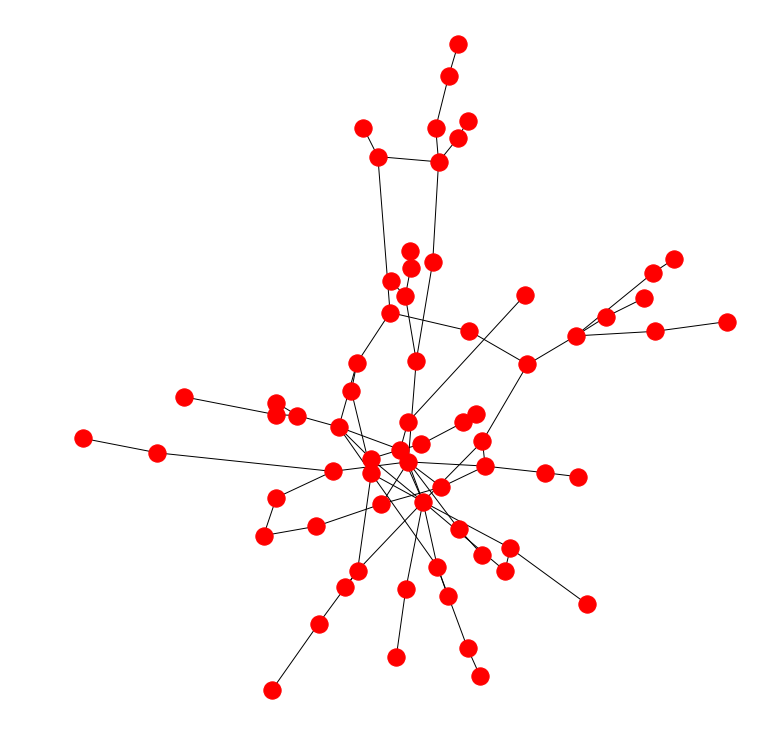

In [2]:
# build matrix from distance-vn.txt file
file_path = "distance-vn.txt"
df = pd.read_csv(file_path, sep=",", header=None)
cities, matrix = graph_matrix(df)

# find degree of the city
def degree_of(cityname):
    iden = cities.id[cities.name == cityname].unique()[0]
    degree = 0
    for entry in matrix[iden]:
        if entry > 0 :
            degree += 1
    return degree

# return a list with distinct cities 
def distinct_city(cities):
    
    distinct = pd.DataFrame(cities.drop_duplicates(keep='first'), columns = ['name', 'id'])
    distinct_sorted = distinct.sort_values(by='id',inplace=False)

    name_h = distinct_sorted.name.tolist()
    id_h = distinct_sorted.id.tolist()
    city = pd.DataFrame(name_h, columns = ['name_city'])
    city['id'] = pd.Series(id_h).values
    
    return city

distinct_city = distinct_city(cities)


# store our graph in 'dictionary'
def build_graph(matrix):
    graph_h = {}
    for i in range(68):
        city = distinct_city.name_city[i]
        graph_h[city] = []
        for j in range(68):
            if (matrix[i,j] != 0):
                neighbor = distinct_city.name_city[j]
                graph_h[city].append(neighbor)
    return graph_h

graph = build_graph(matrix)

def generate_edges(graph):
    edges = []
    for node in graph:
        id_node = distinct_city.id[distinct_city.name_city == node]
        for neighbour in graph[node]:
            id_neighbour = distinct_city.id[distinct_city.name_city == neighbour]
            weight = matrix[id_node, id_neighbour][0]
            edges.append((node, neighbour, weight))

    return edges

generate_edges(graph)


# show the graph
import networkx as nx
plt.rcParams['figure.figsize'] = (10,10)
G = nx.from_numpy_matrix(np.array(matrix))
nx.draw(G)
plt.draw()

,start,end,distance
0,Ha Noi,Hoa Binh,91.60
1,Ha Noi,Ninh Binh,100.00
2,Ha Noi,Vinh,330.00
3,Hoa Binh,Yen Vinh,241.15
4,Ninh Binh,Mai Chau,200.00
5,Ninh Binh,Ha Long,300.00
6,Mai Chau,Son La,190.00
7,Son La,Dien Bien Phu,200.00
8,Dien Bien Phu,Muong Lay,105.00
9,Muong Lay,Sapa,200.00


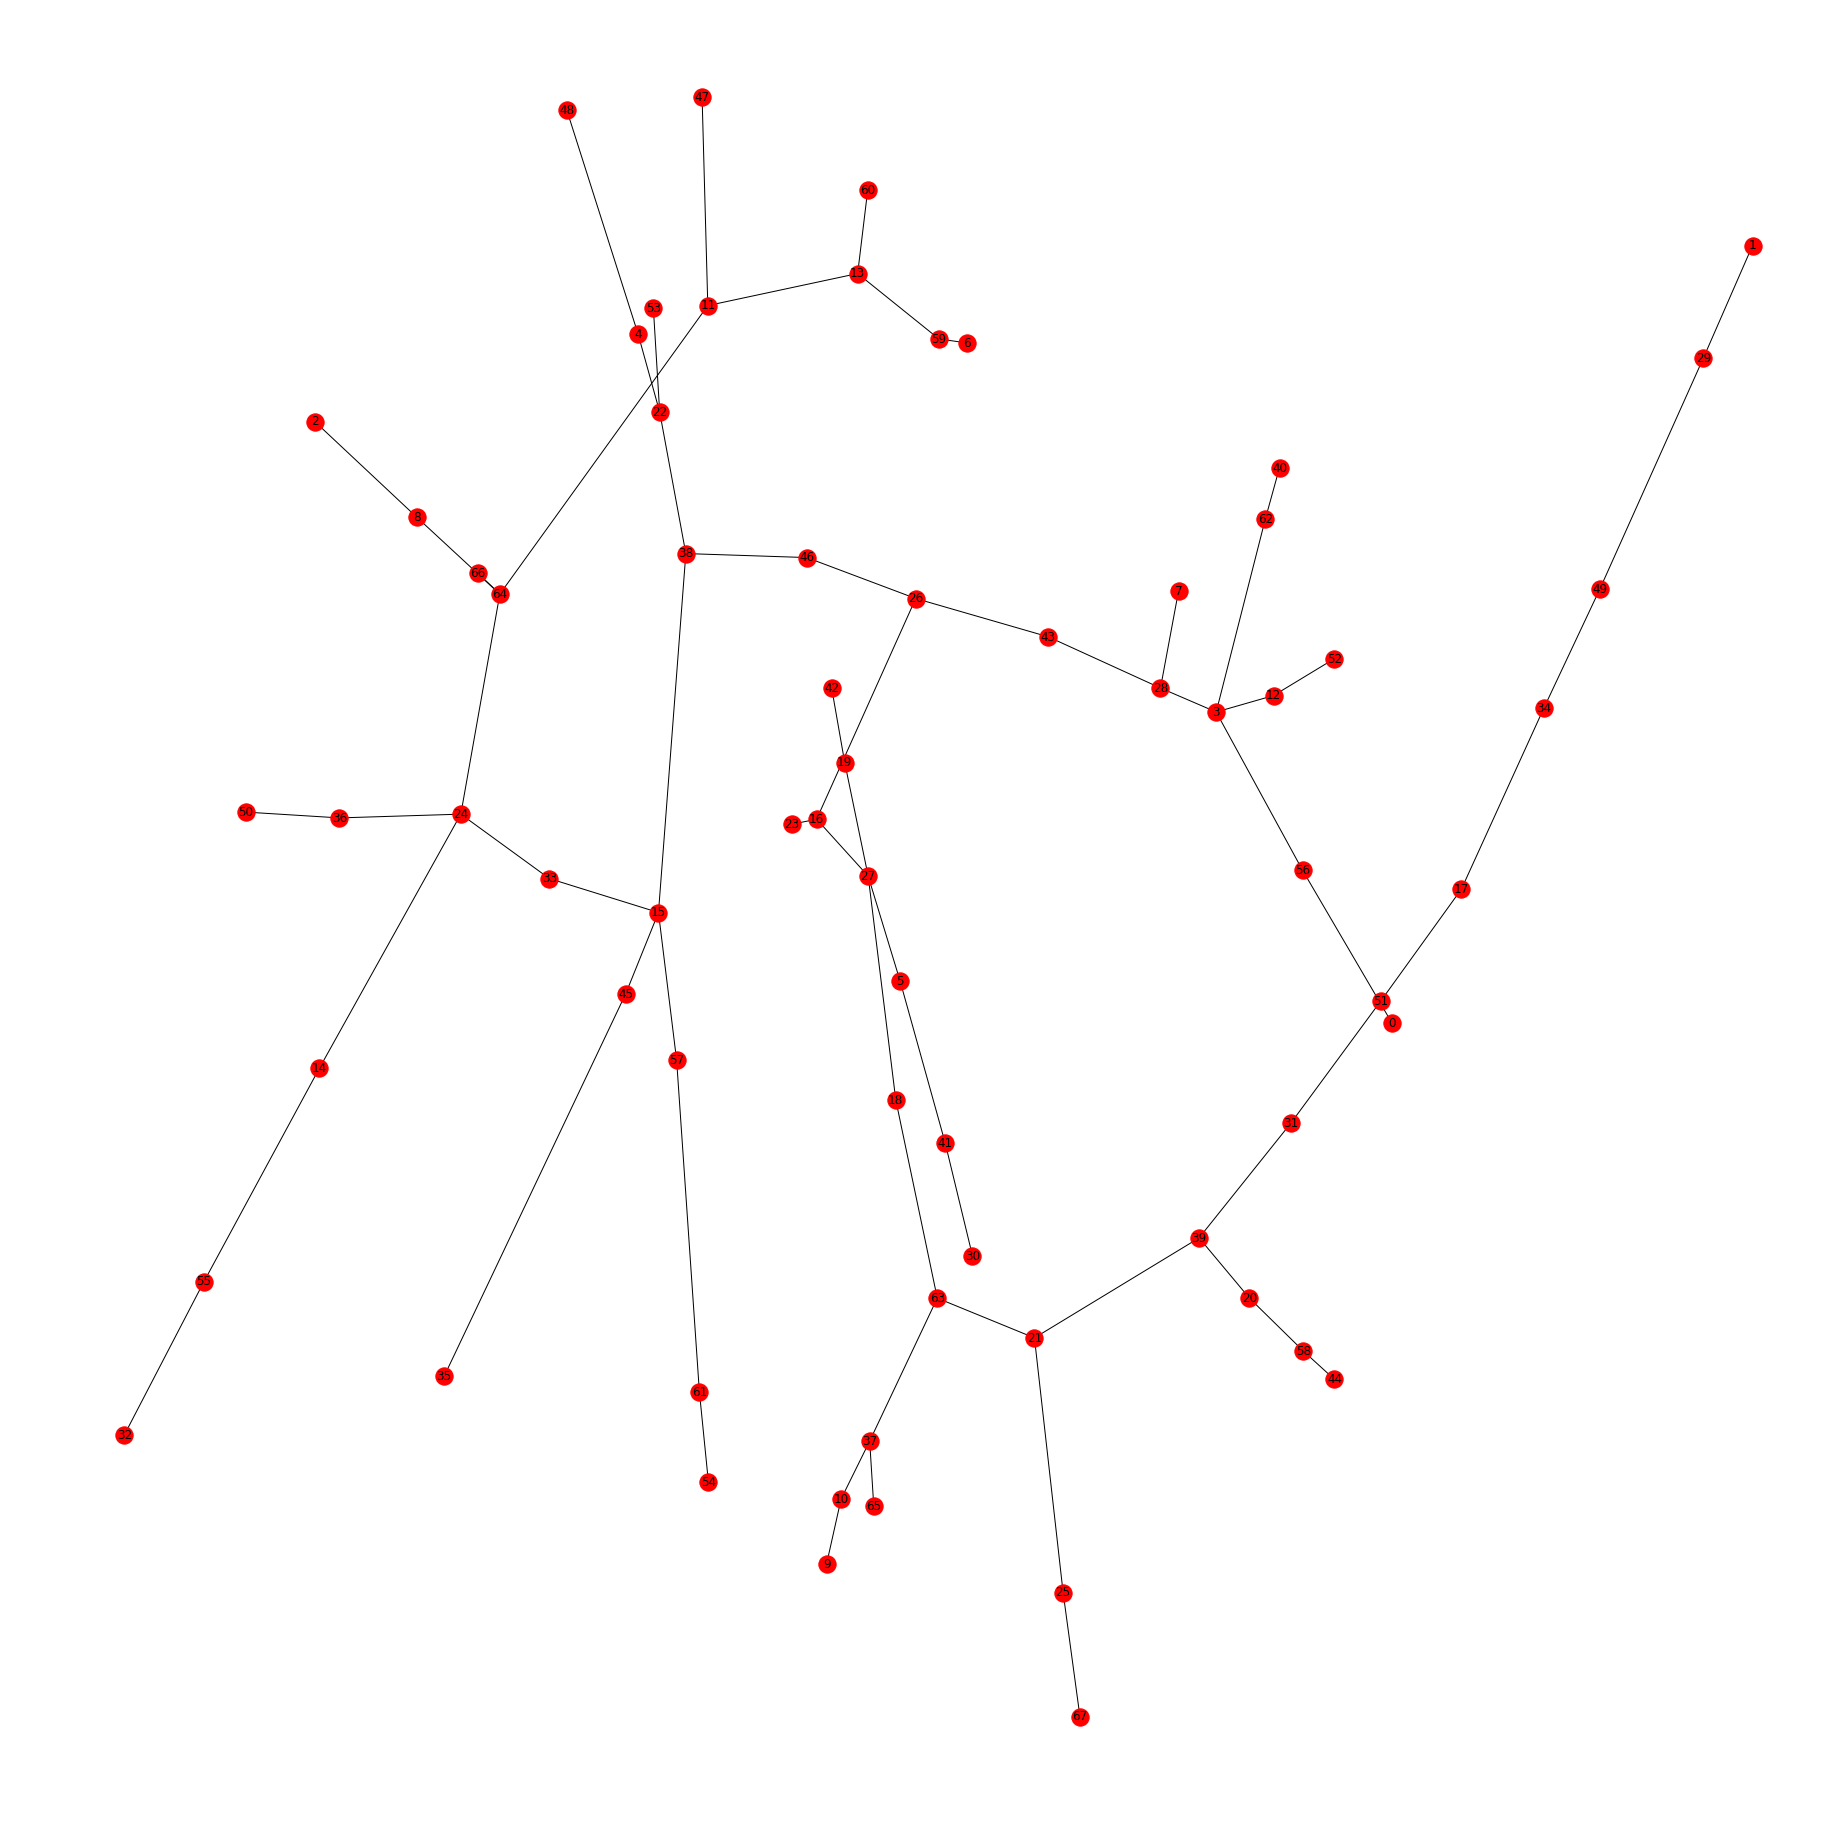

In [3]:
from ipynb.fs.full.adjGraph import Graph, Vertex
def prim(G,start):
    spt = Graph()
    spt.addVertex(start.getId())
    unvisited = {}
    for i in G.getVertices():
        unvisited[i] = G.getVertex(i)
    del unvisited[start.getId()]
    # Find all neighbors
    while unvisited:
        visited = {} # Store weighted vextices which are not in min_G to select minimum value
        root_visited = {}
        for r in spt.getVertices():
            sub_G = []
            root = G.getVertex(r)
            for nbr in root.getConnections():
                sub_G.append(nbr.getId())
            for k in sub_G:
                root_visited[k] = r
    #             ipdb.set_trace()
                if k in unvisited.keys() and k not in spt.getVertices():
                    visited[k] = root.getWeight(G.getVertex(k)) # Weight of all neighbors which are not visited in min_G
        next_vertex = min(visited, key=visited.get)
        if next_vertex not in spt.getVertices():
            spt.addEdge(root_visited[next_vertex], next_vertex, visited[next_vertex])
    #     start = G.getVertex(next_vertex)
            del unvisited[next_vertex]
    return spt
            
                
G = Graph()
for i in generate_edges(graph):
    G.addEdge(i[0],i[1],i[2])
minG = prim(G,G.getVertex("Ha Noi"))
my_list = []
for i in minG.getVertices():
    v = minG.getVertex(i)
    for k in v.getConnections():
        my_list.append((str(v.getId()),str(k.getId()),str(v.getWeight(k))))
df = pd.DataFrame.from_records(my_list)
df[2] = df[2].astype('float')
cities,new_matrix = graph_matrix(df)
plt.rcParams['figure.figsize'] = (25,25)
G = nx.from_numpy_matrix(np.array(new_matrix))
# cities = cities.drop_duplicates(subset=['name'], keep='first')
# cities = cities.sort_values(by='id', ascending=True)
# cities <---- Cities ID
nx.draw(G, with_labels=True)
plt.draw()
df.head(10)

In [4]:
def build_graph(matrix):
    graph_h = {}
    for i in range(68):
        city = distinct_city.name_city[i]
        graph_h[city] = {}
        for j in range(68):
            if (matrix[i,j] != 0):
                neighbor = distinct_city.name_city[j]
                graph_h[city][neighbor] = matrix[i,j]
    return graph_h

graph = build_graph(matrix)
def kruskal(graph):
    assert type(graph)==dict

    nodes = graph.keys()   
    visited = set()
    path = []
    next = None
    pre = None

    while len(visited) < len(nodes):
        distance = float('inf') 
        for s in nodes:
            for d in nodes:
                if s in visited and d in visited or s == d:
                    continue
                try:
                    graph[s][d]
                    if graph[s][d] < distance:
                        distance = graph[s][d]
                        pre
                        pre = s
                        next = d
                except Exception:
                    pass

        path.append((pre, next))
        visited.add(pre)
        visited.add(next)

    return path
path_k = kruskal(graph)
print(path_k)

[('My Lai', 'Quang Ngai'), ('Da Nang', 'Hoi An'), ('Lao Cai', 'Sapa'), ('Can Tho', 'Vinh Long'), ('Cu Chi', 'Ho Chi Minh City'), ('Cu Chi', 'Tay Ninh'), ('Moc Bai', 'Tay Ninh'), ('Bac Lieu', 'Ca Mau'), ('Ben Tre', 'Sa Dec'), ('Can Tho', 'Chau Doc'), ('Can Tho', 'Rach Gia'), ('Bac Ninh', 'Viet Tri'), ('Ha Noi', 'Hoa Binh'), ('Bac Giang', 'Thai Binh'), ('My Tho', 'Soc Trang'), ('Bac Ha', 'Lao Cai'), ('Ha Noi', 'Ninh Binh'), ('Dien Bien Phu', 'Muong Lay'), ('Da Nang', 'Hue'), ('Thai Nguyen', 'Uong Bi'), ('Ha Long', 'Ha Noi'), ('Hoi An', 'Phuoc Son'), ('Bien Hoa', 'Phan Thiet'), ('Da Lat', 'Mui Ne'), ('Cao Bang', 'Son Tay'), ('Dong Hoi', 'Hue'), ('Mai Chau', 'Son La'), ('Dong Hoi', 'Vinh'), ('Chau Doc', 'Tra Vinh'), ('Kon Tum', 'Phuoc Son'), ('Nam Dinh', 'Vinh'), ('Da Lat', 'Nha Trang'), ('Hoa Binh', 'Yen Vinh'), ('Buon Ma Thuot', 'Kon Tum'), ('Nha Trang', 'Quy Nhon'), ('Ha Long', 'Thanh Hoa'), ('Long Xuyen', 'Phan Thiet'), ('Chau Doc', 'Tuy Hoa'), ('Da Nang', 'Hai Phong'), ('Hai Duong', '

In [5]:
def dijkstra(graph,src):
    length = len(graph)
    nodes = list(graph)

    visited = [src]
    path = {src:{src:[]}}
    nodes.remove(src)
    distance_graph = {src:0}
    pre = next = src
    graph[src][src] = 0
    
    while nodes:
        distance = float('inf')
        for v in visited:
             for d in nodes:
                try:
                    new_dist = graph[src][v] + graph[v][d]
                    if new_dist <= distance:
                        distance = new_dist
                        next = d
                        pre = v
                        graph[src][d] = new_dist
                except Exception:
                    pass

        path[src][next] = [i for i in path[src][pre]]
        path[src][next].append(next)

        distance_graph[next] = distance

        visited.append(next)
        if next in nodes:
            nodes.remove(next)

    return distance_graph, path
distance, path_d = dijkstra(graph, 'Ha Noi')
print (distance, '\n\n', path_d)

{'Ha Noi': 0, 'Hoa Binh': 91.6, 'Ninh Binh': 100.0, 'Ha Long': 160.0, 'Mai Chau': 200.0, 'Vinh': 330.0, 'Yen Vinh': 332.75, 'Son La': 390.0, 'Sapa': 400.0, 'Thanh Hoa': 430.0, 'Lao Cai': 438.0, 'Dong Hoi': 530.0, 'Bac Ha': 538.0, 'Nam Dinh': 563.0, 'Dien Bien Phu': 590.0, 'Muong Lay': 600.0, 'Hue': 720.0, 'Da Nang': 850.0, 'Hoi An': 885.0, 'Phuoc Son': 1045.0, 'Buon Ma Thuot': 1086.9, 'Pleiku': 1118.97, 'Ho Chi Minh City': 1146.72, 'Quy Nhon': 1165.0, 'Cu Chi': 1196.72, 'My Tho': 1241.72, 'Tay Ninh': 1246.72, 'Kon Tum': 1265.0, 'Moc Bai': 1301.72, 'Vinh Long': 1326.72, 'Soc Trang': 1334.1, 'Bien Hoa': 1339.2, 'Mui Ne': 1366.72, 'Can Tho': 1371.72, 'Hai Phong': 1406.5700000000002, 'Ha Dong': 1410.0, 'Nha Trang': 1415.0, 'Rach Gia': 1461.72, 'Chau Doc': 1461.72, 'Da Lat': 1486.72, 'Ca Mau': 1506.72, 'Phan Thiet': 1518.2, 'Bac Lieu': 1570.9, 'Tra Vinh': 1666.72, 'Vung Tau': 1686.45, 'Long Xuyen': 1817.72, 'Cam Ranh': 1833.0, 'Tuy Hoa': 1988.37, 'Quang Ngai': 2032.72, 'My Lai': 2044.72, 'B